# Importo librerias

In [1]:
%load_ext autoreload
%autoreload 2


import kaggle
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization #.core

from keras.callbacks import ModelCheckpoint 
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.optimizers import Adam
from keras.models import Model

# Cargo Dataset

In [2]:
folder = 'Cifar100/'

#Para train & validación
x = np.load(folder+'x_train.npy') 
y_coarse = np.load(folder+'y_train_coarse.npy')
y_fine = np.load(folder+'y_train_fine.npy')

#Para test
x_test = np.load(folder+'x_test.npy') 

# Hago Split de los Datos

In [3]:
# Split Course
x_train_coarse, x_val_coarse, y_train_coarse, y_val_coarse = train_test_split(x, y_coarse, test_size = 0.1, stratify=y_coarse)

# Splitplit Fine
x_train_fine, x_val_fine, y_train_fine, y_val_fine = train_test_split(x, y_fine, test_size = 0.1, stratify=y_fine)

# Normalizo las X

In [4]:
x_train_coarse = x_train_coarse/255
x_train_coarse = x_train_coarse.astype('float32')

x_val_coarse = x_val_coarse/255
x_val_coarse = x_val_coarse.astype('float32')

x_test = x_test/255
x_test = x_test.astype('float32')

x_train_fine = x_train_fine/255
x_train_fine = x_train_fine.astype('float32')

x_val_fine = x_val_fine/255
x_val_fine = x_val_fine.astype('float32')

# Normalizo las Y - One Hot Encoding

In [5]:
y_train_fine = y_train_fine.reshape(-1, 1)
y_train_fine = to_categorical(y_train_fine)

y_val_fine = y_val_fine.reshape(-1, 1)
y_val_fine   = to_categorical(y_val_fine)

y_train_coarse = y_train_coarse.reshape(-1, 1)
y_train_coarse = to_categorical(y_train_coarse)

y_val_coarse = y_val_coarse.reshape(-1, 1)
y_val_coarse = to_categorical(y_val_coarse)

# Data Augmentation

In [6]:
# data augmentation para Coarse
x_train_coarse = np.concatenate([x_train_coarse , x_train_coarse[:,::-1]])
y_train_coarse = np.concatenate([y_train_coarse, y_train_coarse])

# data augmentation para fine
x_train_fine = np.concatenate([x_train_fine , x_train_fine[:,::-1]])
y_train_fine = np.concatenate([y_train_fine, y_train_fine])

# Armo el modelo

In [7]:
output_size = np.max(y_fine) + 1 
input_shape = x_train_fine.shape[1:]

model = Sequential()
l2_lambda = regularizers.l2(1e-3)
model.add(Flatten(input_shape=input_shape))

# model.add(Dense(32*32, name='capa1',activation='relu',kernel_regularizer = l2_lambda)) 
# model.add(Dense(32*32/2, name='capa2', activation='relu',kernel_regularizer = l2_lambda))
# model.add(Dense(32*32/4, name='capa3', activation='relu',kernel_regularizer = l2_lambda))

model.add(Dense(100, name='capa1',kernel_regularizer = l2_lambda)) 
# model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Activation("relu"))


model.add(Dense(50, name='capa2',kernel_regularizer = l2_lambda))
model.add(Activation("relu"))
# model.add(BatchNormalization())

model.add(Dense(output_size, name='Salida'))
model.add(Activation('softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
capa1 (Dense)                (None, 100)               307300    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
capa2 (Dense)                (None, 50)                5050      
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
Salida (Dense)               (None, 100)               5

In [8]:
lr = 0.002
model.compile(optimizer=Adam(lr=lr), metrics=['accuracy'], loss ='categorical_crossentropy')

checkpointer = ModelCheckpoint(filepath='cifar_100.hdf5', verbose=1, save_best_only=True, 
                             mode='max', monitor='val_accuracy')

es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=6, mode='max', 
                       restore_best_weights=True)

history =  model.fit(x_train_fine, 
           y_train_fine,
           validation_data = (x_val_fine, y_val_fine),
           epochs=30, 
           batch_size=64, 
           verbose=1,                       
           callbacks=[checkpointer,es])

Epoch 1/30
1407/1407 [==============================] - 8s 5ms/step - loss: 4.5205 - accuracy: 0.0275 - val_loss: 4.2319 - val_accuracy: 0.0500

Epoch 00001: val_accuracy improved from -inf to 0.05000, saving model to cifar_100.hdf5
Epoch 2/30
1407/1407 [==============================] - 7s 5ms/step - loss: 4.2465 - accuracy: 0.0505 - val_loss: 4.0945 - val_accuracy: 0.0814

Epoch 00002: val_accuracy improved from 0.05000 to 0.08140, saving model to cifar_100.hdf5
Epoch 3/30
1407/1407 [==============================] - 7s 5ms/step - loss: 4.1854 - accuracy: 0.0599 - val_loss: 4.0527 - val_accuracy: 0.0858

Epoch 00003: val_accuracy improved from 0.08140 to 0.08580, saving model to cifar_100.hdf5
Epoch 4/30
1407/1407 [==============================] - 7s 5ms/step - loss: 4.1638 - accuracy: 0.0635 - val_loss: 4.1123 - val_accuracy: 0.0716

Epoch 00004: val_accuracy did not improve from 0.08580
Epoch 5/30
1407/1407 [==============================] - 7s 5ms/step - loss: 4.1466 - accuracy: 

# Se muestra el mejor score guardado

In [9]:
model.load_weights('cifar_100.hdf5')

loss, acc = model.evaluate(x_val_fine,y_val_fine, verbose=0)
print("Mi mejor Accuracy y Loss fue:",acc, loss)

Mi mejor Accuracy y Loss fue: 0.21080000698566437 3.521268844604492


# Gráfico Loss & Accuracy

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


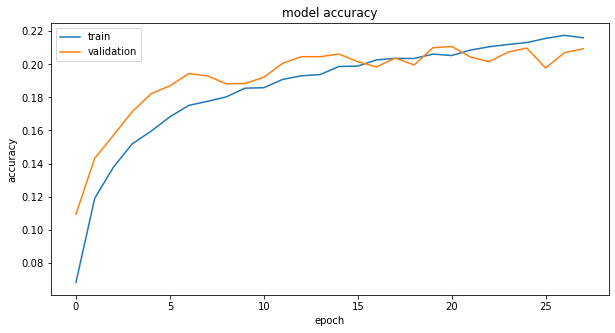

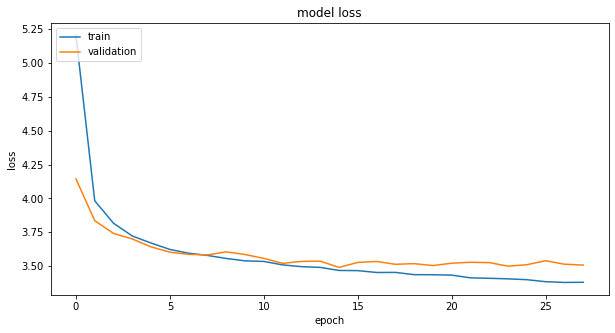

In [10]:
print(history.history.keys())
#  "Accuracy"
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Armo CSV para hacer submit a Kaggle
```diff
- Cuidado al ejecutar estas líneas de código en adelante, necesita tener una cuenta en Kaggle y tener instalado API Kaggle
```

In [11]:
# Calculo probabilidades de cada clase para cada observación
test_prediction = model.predict(x_test)
print(test_prediction.shape)

# Calculo clase
test_labels = np.argmax(test_prediction, axis = 1)
print(test_labels)

import pandas as pd
df = pd.DataFrame(data={"label": test_labels}).astype(int)
df.to_csv("./submission_0.csv", sep=',',index=True,  index_label='Id')


(10000, 100)
[49 80 46 ... 96 42  0]


In [13]:
!kaggle competitions submit -c cifar100-dl-itba-2020q2 -f submission_0.csv -m "Message"

!kaggle competitions leaderboard cifar100-dl-itba-2020q2 --show

!kaggle competitions submissions -c cifar100-dl-itba-2020q2

Successfully submitted to CIFAR100



  0%|          | 0.00/85.7k [00:00<?, ?B/s]
  9%|9         | 8.00k/85.7k [00:00<00:01, 65.5kB/s]
100%|##########| 85.7k/85.7k [00:03<00:00, 27.1kB/s]


 teamId  teamName                submissionDate       score    
-------  ----------------------  -------------------  -------  
6264331  Sebastián Portela       2021-03-23 14:59:06  0.55479  
7158476  Alejandro Chain         2021-07-31 23:22:44  0.30440  
6852054  Gonzalo Pereyra Metnik  2021-05-24 06:46:37  0.30000  
6915346  Eugenio Voss            2021-07-28 14:10:38  0.26379  
6411923  Federico Avila          2021-03-14 22:39:55  0.24120  
fileName              date                 description  status    publicScore  privateScore  
--------------------  -------------------  -----------  --------  -----------  ------------  
submission_0.csv      2021-09-05 11:19:41  Message      complete  0.24160      0.23800       
submission_0.csv      2021-09-05 11:19:06  Message      complete  0.24160      0.23800       
submission_0.csv      2021-09-05 07:50:07  Message      complete  0.21700      0.21980       
submission_0.csv      2021-09-05 07:38:56  Message      complete  0.23640      0.2

competencia: https://www.kaggle.com/c/cifar100-dl-itba-2020q2/leaderboard

paper: https://www.cs.toronto.edu/~kriz/cifar.html